# **Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

In [1]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
  dest_path='./Data_FEI.npz')
  gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
  dest_path='./facial_landmarks_68markup.jpg')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="./"    

Otherwise, you can also load them from your local machine using the following code

In [2]:
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""      

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

Let's load the Python packages containing the functions needed for the practical session.

In [3]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.pipeline import make_pipeline

We also load a user-defined function useful for plotting the confusion matrix

In [4]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark configurations should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [5]:
# Parameters
dim=2 # dimension   
# Loading data
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

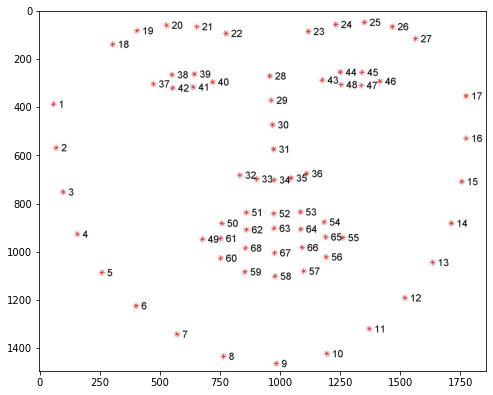

In [6]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

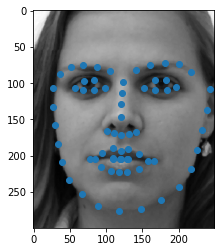

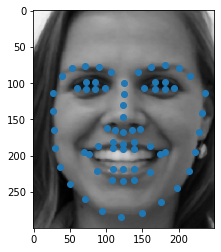

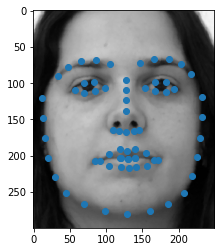

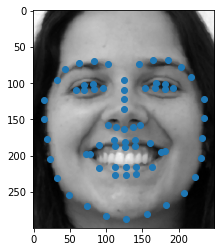

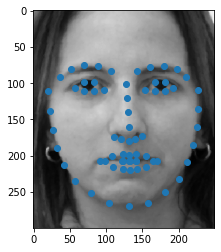

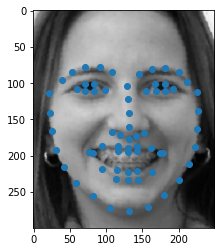

In [7]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---



## **Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?




---

Les visages à la suite sont de la même personne. Donc afin d'avoir des données plus représentatives dans les test/training set il est préférable de mélanger les données.

In [8]:
# Shuffle data randomly. Hint: Use np.random.shuffle
indeces=np.arange(N)
np.random.shuffle(indeces)
XpGPA=XGPA[indeces]
Xp=X[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]
Xmean = np.mean(XpGPA,axis=0) # Compute average

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]]   

In [9]:
print("Number of neutral faces",np.count_nonzero(Yp==0),", Number of happy faces",np.count_nonzero(Yp==1))

Number of neutral faces 200 , Number of happy faces 200




---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. Let's check them and compare them with the landmarks before alignement.


## **QUESTION**: Please comment the results. What can you notice ?




---

On voit bien qu'avant la GPA les données sont très dispersées et on voit difficielement des motifs. Après la GPA, les données sont bien alignés sur une forme moyenne et donc on constate bien, en particulier autour de la bouche, qu'il y a deux classes de données.

Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

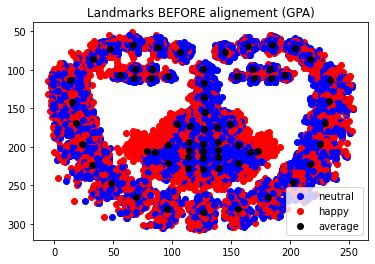

In [10]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

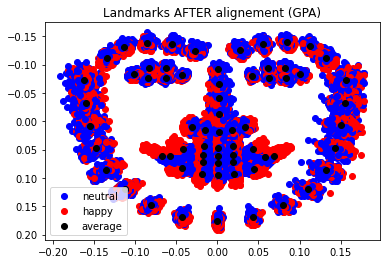

In [11]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the landmarks of every subject and the landmarks of the average configuration. 



---



In [12]:
# Compute distances from the average configuration (features)
dist_average=np.zeros((N,M))
average=np.reshape(Xmean,(M,2)) # Reshape average as matrix

for i in range(N):
    landmark=XpGPA[i].reshape((M,2)) # Reshape all landmarks as matrices
    dist_average[i]=paired_distances(landmark,average)  

print('Number of subjects N is: ', dist_average.shape[0], ' ; number of features is: ',  dist_average.shape[1] )


Number of subjects N is:  400  ; number of features is:  68


Let's divide the data-set into Training and Test sets:

In [13]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33,random_state=314)

---

## **Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.

De manière générale le modèle de régression que l'on va choisir va imposer des contraintes sur les données. Ici on va centrer les données car on n'a pas besoin de l'ordonnée à l'origine pour chaque modèle. On peut les réduire aussi mais ce n'est pas nécessaire. Il n'est pas nécessaire de normaliser les données au vu des modèles que l'on va utliser.

Please note that we compute the parameters of 'StandardScaler()' and 'MinMaxScaler()' using only the training set and then we trasform both the traning and test sets using the parameters learnt only on the training set.

**Question**: Why do we do that in your opinion ?

Il est important de bien séparer les jeux d'apprentissage et de test. Ainsi tout le modèle doit être uniquement entrainé sur un jeu de données, or ces pré-processing font aussi partie du modèle. Donc on transforme les données test avec les paramètres appris sur les données d'apprentissage.

---

In [14]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=minmaxscaler#sklearn.preprocessing.MinMaxScaler

normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)




---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 

## **Question**: Compare the performances between original, scaled and normalized data. Comment the results.

On obtient les mêmes résultats dans tous les cas de figure. En effet pour la LDA, la classification d'une donnée $x$ revient à maximiser $f^*(x)={arg min}_{C_k} a_k + x^T b_k$. On peut vérifier assez rapidement qu'avec la définition des coefficients $a_k$ et $b_k$, on a invariance du résultat sur les transformations utilisées sur le jeu de données.

La classification va avoir tendance à identifier correctement 2 tiers des visages neutres mais va classifier les visages heureux correctement seulemnt la moitié du temps.

---



Fitting LDA to training set
done in 0.018s
              precision    recall  f1-score   support

           0       0.51      0.66      0.58        61
           1       0.61      0.46      0.53        71

    accuracy                           0.55       132
   macro avg       0.56      0.56      0.55       132
weighted avg       0.57      0.55      0.55       132

Normalized confusion matrix
[[0.6557377  0.3442623 ]
 [0.53521127 0.46478873]]


<Figure size 432x288 with 0 Axes>

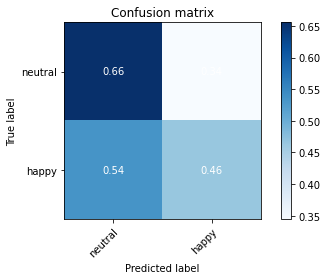

In [15]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training set
done in 0.017s
              precision    recall  f1-score   support

           0       0.51      0.66      0.58        61
           1       0.61      0.46      0.53        71

    accuracy                           0.55       132
   macro avg       0.56      0.56      0.55       132
weighted avg       0.57      0.55      0.55       132

Normalized confusion matrix
[[0.6557377  0.3442623 ]
 [0.53521127 0.46478873]]


<Figure size 432x288 with 0 Axes>

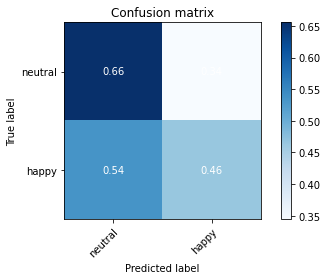

In [16]:
# Fitting LDA to scaled data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred_scale = lda.predict(X_test_scale)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred_scale))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_scale)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training set
done in 0.035s
              precision    recall  f1-score   support

           0       0.51      0.66      0.58        61
           1       0.61      0.46      0.53        71

    accuracy                           0.55       132
   macro avg       0.56      0.56      0.55       132
weighted avg       0.57      0.55      0.55       132

Normalized confusion matrix
[[0.6557377  0.3442623 ]
 [0.53521127 0.46478873]]


<Figure size 432x288 with 0 Axes>

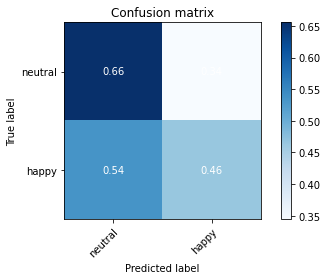

In [17]:
# Fitting LDA to normalized data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_normalize, y_train)
y_pred = lda.predict(X_test_normalize)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()



---

We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today. 

---






## Cross-validation for Model Assessment

In [18]:
# Cross-validation for Model Assessment
result ={}
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
result["LDA" ]= lda_score.mean()
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
result["QDA"] = qda_score.mean()
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
result["Logit"] = logit_score.mean()
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
result["GNB"] = GNB_score.mean()
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
result["KNN"] = neigh_score.mean()
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))


Fitting LDA
done in 0.130s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.154s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.068s
 Average and std CV score : 0.5349999999999999 +- 0.0483476990145343
Fitting Naive-Bayes
done in 0.035s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.121s
 Average and std CV score : 0.6049999999999999 +- 0.032210246816812824


---
## **Question**: compare the performances between original, scaled and normalized data

Be careful, if you want to standardize your data within a cross validation it means that you should fit 'StandardScaler()' only to the K-1 training folds without using the K-th test fold ! And then transform all folds.
How can we do that ? 

Scikit-learn gives us a very nice tool: THE PIPELINE ! It makes it easier to chain standardization, normalizations, etc. with estimators during a cross validation. Please have a look here: https://scikit-learn.org/stable/common_pitfalls.html

How can we build a Pipeline? It's very simple. Just concatenate the trasformation and the the estimator you want to use:

model = make_pipeline(StandardScaler(), LinearRegression())

---

**Answer**: Il semble que globalement il est préférable d'utiliser les données de base et de classifier par la méthode des plus proches voisins.

In [19]:
def cross_val(p,X,y):
  # Cross-validation for Model Assessment with Standaridzation
  result_std = {}
  # Fitting LDA
  print("Fitting LDA")
  t0 = time()
  lda = make_pipeline(p, LinearDiscriminantAnalysis())
  lda_score = cross_val_score(lda,X, y,cv=5)
  result_std["LDA"] = lda_score.mean()
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

  # Fitting QDA
  print("Fitting QDA")
  t0 = time()
  lda = make_pipeline(p, QuadraticDiscriminantAnalysis())
  lda_score = cross_val_score(lda,X, y,cv=5)
  result_std["QDA"] = lda_score.mean()
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))


  # Fitting Logistic-regression
  print("Fitting Logit")
  t0 = time()
  lda = make_pipeline(p, LogisticRegression())
  lda_score = cross_val_score(lda,X, y,cv=5)
  result_std["Logit"] = lda_score.mean()
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))


  # Fitting Naive-Bayes
  print("Fitting GNB")
  t0 = time()
  lda = make_pipeline(p, GaussianNB())
  lda_score = cross_val_score(lda,X, y,cv=5)
  result_std["GNB"] = lda_score.mean()
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))


  # Fitting K-nearest neighbour
  print("Fitting KNN")
  t0 = time()
  lda = make_pipeline(p, KNeighborsClassifier())
  lda_score = cross_val_score(lda,X, y,cv=5)
  result_std["KNN"] = lda_score.mean()
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

  return result_std

### Cross-validation for Model Assessment with Standaridzation

In [20]:
result_std = cross_val(StandardScaler(),X=dist_average, y=np.ravel(Yp))

Fitting LDA
done in 0.146s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.183s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logit
done in 0.586s
 Average and std CV score : 0.55 +- 0.01767766952966367
Fitting GNB
done in 0.025s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting KNN
done in 0.059s
 Average and std CV score : 0.5599999999999999 +- 0.044300112866673375


### Cross-validation for Model Assessment with Normalized data

In [21]:
result_norm = cross_val(MinMaxScaler(),X=dist_average, y=np.ravel(Yp))

Fitting LDA
done in 0.182s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.157s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logit
done in 0.324s
 Average and std CV score : 0.5675000000000001 +- 0.03409545424246464
Fitting GNB
done in 0.053s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting KNN
done in 0.134s
 Average and std CV score : 0.5725 +- 0.053851648071345015


### Best method and data

In [22]:
#Best method
best_method = np.argmax(list(result.values()))
name_best_method = list(result.keys())[best_method]
print("\n The best method with the raw data is ",name_best_method,"with an accuracy of",result[name_best_method])


 The best method with the raw data is  KNN with an accuracy of 0.6049999999999999


In [23]:
#Best method
best_method = np.argmax(list(result_std.values()))
name_best_method = list(result_std.keys())[best_method]
print("\n The best method with the standardized data is ",name_best_method,"with an accuracy of",result_std[name_best_method])


 The best method with the standardized data is  GNB with an accuracy of 0.5725


In [24]:
#Best method
best_method = np.argmax(list(result_norm.values()))
name_best_method = list(result_norm.keys())[best_method]
print("\n The best method with the normalized data is ",name_best_method,"with an accuracy of",result_norm[name_best_method])


 The best method with the normalized data is  GNB with an accuracy of 0.5725



---

In the previous example we have fixed the hyper-parameter K to 3. We could use CV to find the best value.

---



The best K is 7  with an average validation score equal to  0.6399999999999999


Text(0, 0.5, 'CV Validation Score')

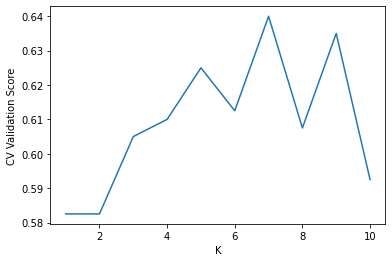

In [25]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 6  with an average validation score equal to  0.6234800838574424
The test score is 0.6060606060606061


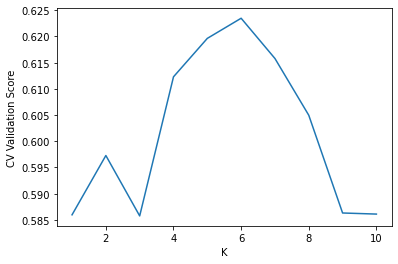

In [26]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))

---
## **Question**: Comment the results of the two previous experiments. What about the best K and validation/test error ? Are the results the same ? Why in your opinion ?
---
**Answer**: 
On voit que lorsque l'on cherche le meilleur paramètre sur le jeu de données entier on trouve K = 7 pour un score de validation de 0.64 contre K = 5 pour un score de validation de 0.62 mais un score de test 0.60 lorsque l'on cherche uniquement sur X_train.

 Plus l'écart que l'on trouve entre le score de validation et le score de test est important plus cela traduit le fait que l'on a overfit le modèle. De même plus l'écart de score de validation entre le modèle entrainé sur toutes les données et celui entrainé uniquement sur X_train est important plus cela veut dire que le modèle est underfit (si le premier est plus élevé que le deuxième).

 Au vu des résultats ici on peut dire que les données sont bien équilibrés et que le modèle est entrainé correctement, pas nécessairement qu'il est bon en revanche. Par contre je ne sais pas pourquoi le paramètre K est différent. Peut etre on a une valeur de K plus élevée dans le premier cas car on travaille sur plus de données et donc il faut considérer plus de voisins pour avoir un résultat satisfaisant.



---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [27]:
dist_combination= dist_average

In [28]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))
for k in range(N):
  landmark_k = XpGPA[k].reshape((M,2))
  dist_sub_k =[]
  for i in range(M):
    for j in range(i+1,M):
      a = paired_distances(landmark_k[i].reshape(1, -1),landmark_k[j].reshape(1, -1))
      dist_sub_k = np.append(dist_sub_k, a)
  dist_combination[k] = dist_sub_k

print('Number of subjects N is: ', dist_combination.shape[0], ' ; number of features is: ',  dist_combination.shape[1] )

Number of subjects N is:  400  ; number of features is:  2278


In [29]:
X2_train, X2_test, y2_train, y2_test = train_test_split(dist_combination, np.ravel(Yp), test_size=0.33, random_state=42)

## **Question**: Should we scale/normalize the new features ?

**Answer**: Il semble qu'il est préférable maintenant de normaliser les données au vu des résultats.

Use the classification algorithms seen before to test the discriminative power of the new features. 

### Nothing

In [30]:
result2 = cross_val(FunctionTransformer(lambda x : x),X=dist_combination, y=np.ravel(Yp))

Fitting LDA
done in 1.687s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.907s
 Average and std CV score : 0.6175 +- 0.060518592184550996
Fitting Logit
done in 0.409s
 Average and std CV score : 0.9475 +- 0.019999999999999976
Fitting GNB
done in 0.110s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting KNN
done in 0.093s
 Average and std CV score : 0.945 +- 0.02915475947422651


### Normalized

In [31]:
result2_norm = cross_val(MinMaxScaler(),dist_combination,np.ravel(Yp))

Fitting LDA
done in 1.706s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.955s
 Average and std CV score : 0.5725 +- 0.0544288526426931
Fitting Logit
done in 0.886s
 Average and std CV score : 0.975 +- 0.032596012026013255
Fitting GNB
done in 0.160s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting KNN
done in 0.163s
 Average and std CV score : 0.9375 +- 0.028504385627478448


### Standardized

In [32]:
result2_std = cross_val(StandardScaler(),dist_combination,np.ravel(Yp))

Fitting LDA
done in 1.784s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 1.013s
 Average and std CV score : 0.6174999999999999 +- 0.06919176251549024
Fitting Logit
done in 0.836s
 Average and std CV score : 0.9625 +- 0.0262202212042538
Fitting GNB
done in 0.170s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting KNN
done in 0.175s
 Average and std CV score : 0.9349999999999999 +- 0.020000000000000007


### Comparaison

In [33]:
#Best method
best_method = np.argmax(list(result2.values()))
name_best_method = list(result2.keys())[best_method]
print("\n The best method with the raw data is ",name_best_method,"with an accuracy of",result2[name_best_method])

#Best method
best_method = np.argmax(list(result2_std.values()))
name_best_method = list(result2_std.keys())[best_method]
print("\n The best method with the standardized data is ",name_best_method,"with an accuracy of",result2_std[name_best_method])

#Best method
best_method = np.argmax(list(result2_norm.values()))
name_best_method = list(result2_norm.keys())[best_method]
print("\n The best method with the normalized data is ",name_best_method,"with an accuracy of",result2_norm[name_best_method])


 The best method with the raw data is  Logit with an accuracy of 0.9475

 The best method with the standardized data is  Logit with an accuracy of 0.9625

 The best method with the normalized data is  Logit with an accuracy of 0.975




---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. 

## **Question**: Which technique could you use to reduce the collinearity/redundancy ? Use it and test the predictive power of the new features.

---

**Answer**: On pourrait utiliser une PCA. On trouve des meilleurs résulats et ceux pour les données standardiser avec la régression logistique.

In [34]:
from numpy.ma.core import identity
#Preprocessing
PCA = decomposition.PCA(n_components= 0.95)
dist_combinationPCA = PCA.fit_transform(dist_combination)

print("We keep",PCA.n_components_,"components")
from sklearn.preprocessing import FunctionTransformer
print("\n No preprocess")
resultPCA = cross_val(FunctionTransformer(lambda x : x),dist_combinationPCA,np.ravel(Yp))
print("\nStandardScaler")
resultPCA_std = cross_val(StandardScaler(),dist_combinationPCA, np.ravel(Yp))
print("\nMixMaxScaler")
resultPCA_norm = cross_val(MinMaxScaler(),dist_combinationPCA, np.ravel(Yp))

We keep 13 components

 No preprocess
Fitting LDA
done in 0.026s
 Average and std CV score : 0.9625 +- 0.028504385627478455
Fitting QDA
done in 0.019s
 Average and std CV score : 0.9674999999999999 +- 0.02318404623873926
Fitting Logit
done in 0.041s
 Average and std CV score : 0.9475 +- 0.019999999999999976
Fitting GNB
done in 0.021s
 Average and std CV score : 0.9549999999999998 +- 0.02318404623873926
Fitting KNN
done in 0.036s
 Average and std CV score : 0.9400000000000001 +- 0.022912878474779203

StandardScaler
Fitting LDA
done in 0.024s
 Average and std CV score : 0.9625 +- 0.028504385627478455
Fitting QDA
done in 0.022s
 Average and std CV score : 0.9674999999999999 +- 0.02318404623873926
Fitting Logit
done in 0.043s
 Average and std CV score : 0.9724999999999999 +- 0.031024184114977156
Fitting GNB
done in 0.018s
 Average and std CV score : 0.9549999999999998 +- 0.02318404623873926
Fitting KNN
done in 0.035s
 Average and std CV score : 0.8775000000000001 +- 0.03201562118716426

Mi

In [35]:
#Best method
best_method = np.argmax(list(resultPCA.values()))
name_best_method = list(resultPCA.keys())[best_method]
print("\n The best method with the raw data is ",name_best_method,"with an accuracy of",resultPCA[name_best_method])

#Best method
best_method = np.argmax(list(resultPCA_std.values()))
name_best_method = list(resultPCA_std.keys())[best_method]
print("\n The best method with the standardized data is ",name_best_method,"with an accuracy of",resultPCA_std[name_best_method])

#Best method
best_method = np.argmax(list(resultPCA_norm.values()))
name_best_method = list(resultPCA_norm.keys())[best_method]
print("\n The best method with the normalized data is ",name_best_method,"with an accuracy of",resultPCA_norm[name_best_method])


 The best method with the raw data is  QDA with an accuracy of 0.9674999999999999

 The best method with the standardized data is  Logit with an accuracy of 0.9724999999999999

 The best method with the normalized data is  QDA with an accuracy of 0.9674999999999999




---


A second solution, would be to manually select few landmarks



---



In [36]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  12


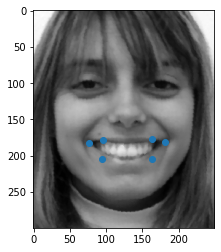

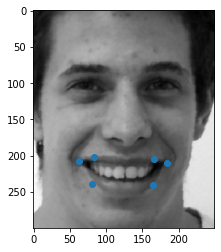

In [37]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

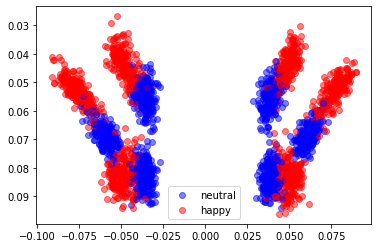

In [38]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b',alpha=0.5)
    else:
        happy=plt.scatter(x, y, c='r',alpha=0.5)
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [39]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.95625 +- 0.006846531968814562
 Average and std test score : 0.9400000000000001 +- 0.021505813167606556


---

Let's plot some images where the best model was wrong. 

---

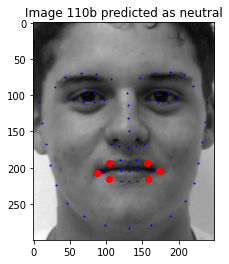

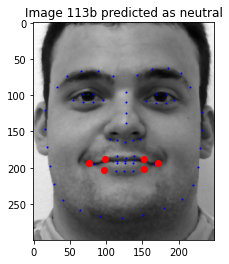

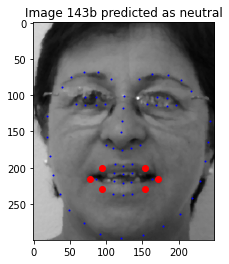

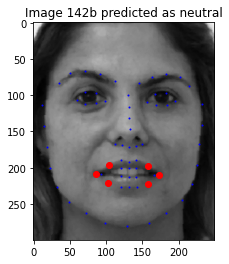

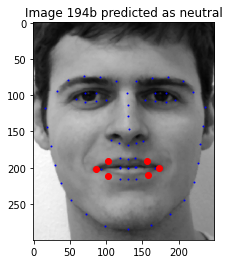

In [40]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob',markersize = 1)
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 

## **Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks

**Answer** : Si l'algorithme se trompe c'est car déjà à l'oeil nu il est compliqué de distinguer si le visage est neutre où non. De plus comme on peut le voir sur le graphe avec uniquement les landmarks sélectionnés, il y a un recouvrement de données entre les deux classes. On peut essayer avec les sourcils [18-27] ou avec les yeux [37-48] mais on obtient des résultats moins biens.

Number of subjects N is:  400  ; number of features is:  24


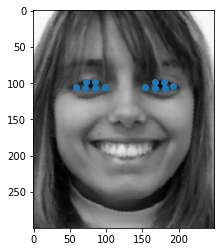

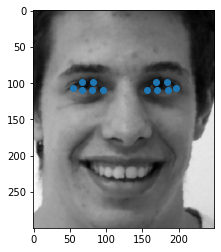

In [41]:
# Select landmarks eyebrows
select_land=[k for k in range(37,49)]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)  
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]   
Yps=Yp
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

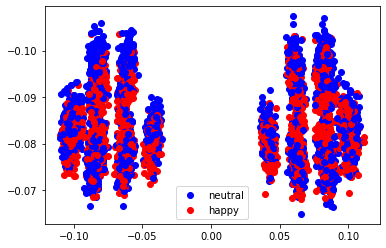

In [42]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [43]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.8975 +- 0.012405895775799524
 Average and std test score : 0.8625 +- 0.02738612787525829





---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [44]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 1.449s
Average and std Nested Cv train score : 0.8006249999999999 +- 0.013891319231808039
Average and std Nested Cv test score : 0.7474999999999999 +- 0.053268189381656283


---

## **Question**: Are Training and Test scores similar ? What does it mean ?

---
**Answer**: Ces deux valeurs ont bien un sens différents. Le training score indique à quel point le modèle est adapté au jeu de données qui l'entraine. Il permet de juger de la viabilité du modèle. Le test score est lui un score de prédiction qui permet de juger de l'apprentissage du modèle.

**Question (OPTIONAL)**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power